In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense

In [ ]:
df=pd.read_csv('/content/MRTSSM448USN.csv',index_col='DATE',parse_dates=True)

In [ ]:
df

,MRTSSM448USN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2022-01-01,18113
2022-02-01,20509
2022-03-01,25622


In [ ]:
df.columns=['Sales']

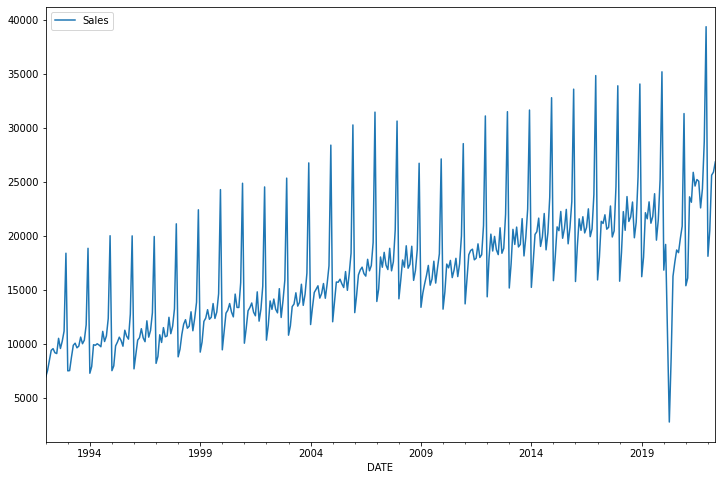

In [ ]:
df.plot(figsize=(12,8))

In [ ]:
len(df)

365

In [ ]:
test_size = 18

In [ ]:
test_ind = len(df)- test_size

In [ ]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [ ]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2020-07-01,17567
2020-08-01,18694
2020-09-01,18449


In [ ]:
test

,Sales
DATE,
2020-12-01,31329
2021-01-01,15385
2021-02-01,16102
2021-03-01,23616
2021-04-01,23115
2021-05-01,25886
2021-06-01,24618
2021-07-01,25219
2021-08-01,25063


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler()

In [ ]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [ ]:
X,y = generator[0]

In [ ]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.12878064 0.14684754 0.17616772 0.20471713 0.20955758 0.19796516
 0.19552952 0.23900108 0.21002004 0.23101588 0.2597811  0.48201017]
Predict this y: 
 [[0.14616926]]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
n_features = 1

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [ ]:
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


335/335 [==============================] - 5s 7ms/step - loss: 0.0245 - val_loss: 0.0615
Epoch 2/20
335/335 [==============================] - 2s 6ms/step - loss: 0.0159 - val_loss: 0.0331
Epoch 3/20
335/335 [==============================] - 2s 6ms/step - loss: 0.0102 - val_loss: 0.0176
Epoch 4/20
335/335 [==============================] - 2s 6ms/step - loss: 0.0064 - val_loss: 0.0068
Epoch 5/20
335/335 [==============================] - 3s 10ms/step - loss: 0.0055 - val_loss: 0.0082
Epoch 6/20
335/335 [==============================] - 3s 9ms/step - loss: 0.0047 - val_loss: 0.0166


In [ ]:
losses = pd.DataFrame(model.history.history)

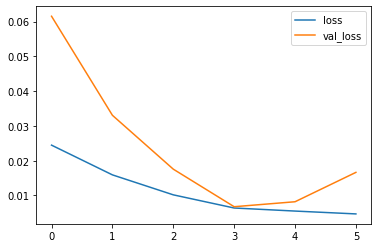

In [ ]:
losses.plot()

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)



In [ ]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test

,Sales,Predictions
DATE,,
2020-12-01,31329,30940.396033
2021-01-01,15385,17658.842457
2021-02-01,16102,18641.331718
2021-03-01,23616,15136.034354
2021-04-01,23115,13808.150718
2021-05-01,25886,14659.654687
2021-06-01,24618,17148.385889
2021-07-01,25219,17845.902439
2021-08-01,25063,18484.921904


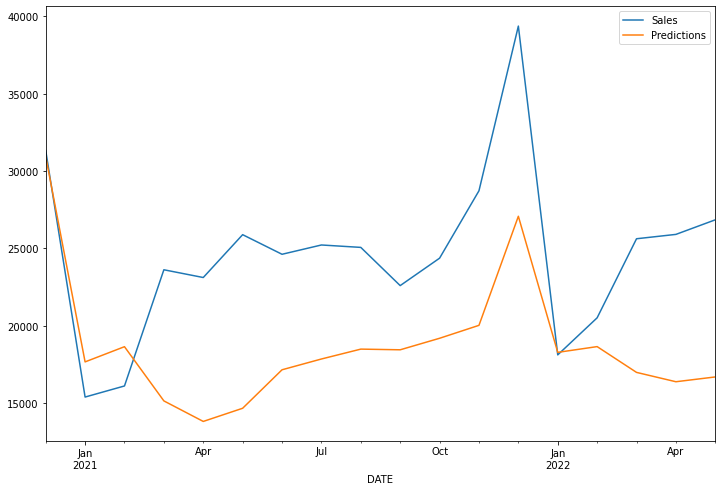

In [ ]:
test.plot(figsize=(12,8))

In [ ]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [ ]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


353/353 [==============================] - 4s 6ms/step - loss: 0.0175
Epoch 2/8
353/353 [==============================] - 2s 6ms/step - loss: 0.0125
Epoch 3/8
353/353 [==============================] - 2s 6ms/step - loss: 0.0096
Epoch 4/8
353/353 [==============================] - 3s 9ms/step - loss: 0.0067
Epoch 5/8
353/353 [==============================] - 3s 7ms/step - loss: 0.0048
Epoch 6/8
353/353 [==============================] - 2s 6ms/step - loss: 0.0046
Epoch 7/8
353/353 [==============================] - 2s 6ms/step - loss: 0.0055
Epoch 8/8
353/353 [==============================] - 3s 8ms/step - loss: 0.0053


In [ ]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
forecast = scaler.inverse_transform(forecast)

In [ ]:
forecast_index = pd.date_range(start='2022-05-01',periods=periods,freq='MS')

In [ ]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [ ]:
forecast_df

,Forecast
2022-05-01,22303.244791
2022-06-01,22662.377996
2022-07-01,22563.610758
2022-08-01,21067.146365
2022-09-01,21820.666073
2022-10-01,25443.748318
2022-11-01,36421.299143
2022-12-01,20027.298718
2023-01-01,20347.439665
2023-02-01,22794.712716


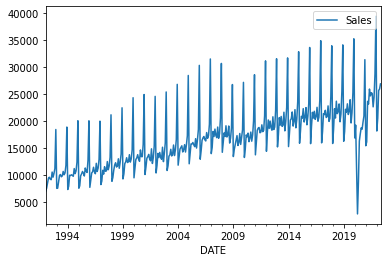

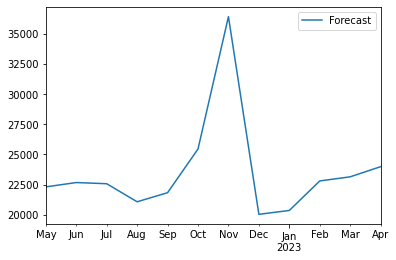

In [ ]:
df.plot()
forecast_df.plot()

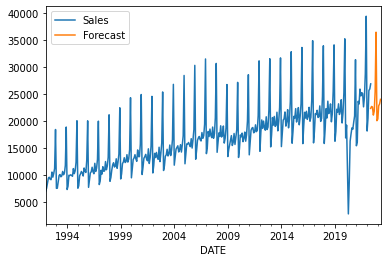

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax)

(616.0, 639.0)

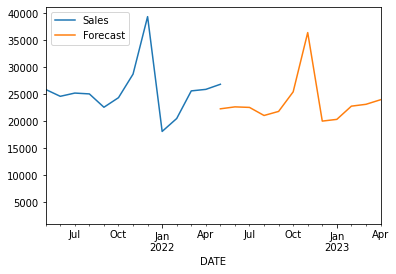

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2021-05-01','2023-04-01	')